In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from util import Util
from qos_data_manager import QosDataManager
from matplotlib.backends.backend_pdf import PdfPages
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import metrics as m
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.backends.backend_pdf import PdfPages
#from keras.utils.vis_utils import plot_model

####
#dodano
####

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 
mode = 'qos'
excel_file_video = r"video_dataset_with_costs(qos).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(qos).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video

used_features = [#'Users',
                 'Avg RAM used (MB)',
                 #'Avg RAM (unused, KiB)',
                 'Disk read bytes', 
                 'Disk write bytes rate',
                 'End-to-end', 
                 #'No. SLO violations, threshold 5s (%)',
                 'Avg. CPU utilization (%)',
                 #'Max CPU utilization (%)', 
                 #'Min RAM',
                 #'Min free RAM (KiB)', 
                 'NW Ingress (GB)',
                 'NW Egress (GB)']
outcome_label = 'End-to-end'
############################################################

dataManager = QosDataManager(excel_file, outcome_label, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()        

def transformX(X):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)       
    return X

def transformY(Y):
    data = Y.copy().values
    data = np.sqrt(data)
    ret = pd.Series(data)
    return ret

def invTrans(X):
    return X*X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print(len(working_metrics))

util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


Using TensorFlow backend.


21 features removed (std +/- 3) -  large
1 features removed (std +/- 3) -  medium
16 features removed (std +/- 3) -  small
15 features removed (std +/- 3) -  all
236


# Neural net

In [2]:
import keras 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


def baseline_model():
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'tanh', kernel_initializer='glorot_normal', input_dim = X.shape[1]))
    
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))

    model.add(Dense(units = 1))
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.compile(optimizer = adam, loss = 'mse')
    return model

In [3]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


# Splitting the dataset into the Training set and Test set
X,Y = dataManager.getXY_panda(working_metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

#Zakomentirano za Permutation Importance 
#model = baseline_model()
# Fitting the ANN to the Training set
#history = model.fit(X_train, Y_train, batch_size = 50, epochs = 500)

####dodano za Permutation Importance 
my_model = KerasRegressor(build_fn=baseline_model, batch_size = 50, epochs = 500)    
my_model.fit(X_train,Y_train)
perm = PermutationImportance(my_model, n_iter=150, random_state=1).fit(X_test,Y_test)
print("Eli5.show_weights")
print("=================")
print("")
eli5.show_weights(perm, feature_names = X.columns.tolist())

#odkomentirati poslije permutation importance analize
#Y_pred = model.predict(X_test)
#Y_pred = np.concatenate( Y_pred, axis=0 )

#odkomentirati poslije permutation importance analize
#plt.plot(Y_test.values, color = 'red', label = 'Real data')
#plt.plot(Y_pred, color = 'blue', label = 'Predicted data')
#plt.title('Prediction')
#plt.legend()
#plt.show()

#Plot the neural network, missing pydot package
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#plot_model(model, show_shapes=True, show_layer_names=True)

#odkomentirati poslije permutation importance analize
#model_info = {}
#model_info['model'] = model
#model_info['X_train'] = X_train
#model_info['X_test'] = X_test
#model_info['Y_train'] = Y_train
#model_info['Y_test'] = Y_test
#model_info['predicted'] = model.predict(X_test)[:,0]


Epoch 1/500
165/165 [==============================] - 0s 2ms/step - loss: 3764.7310
Epoch 2/500
165/165 [==============================] - 0s 145us/step - loss: 2553.1970
Epoch 3/500
165/165 [==============================] - 0s 109us/step - loss: 1268.5485
Epoch 4/500
165/165 [==============================] - 0s 164us/step - loss: 751.5420
Epoch 5/500
165/165 [==============================] - 0s 103us/step - loss: 332.6845
Epoch 6/500
165/165 [==============================] - 0s 194us/step - loss: 219.8466
Epoch 7/500
165/165 [==============================] - 0s 194us/step - loss: 188.6589
Epoch 8/500
165/165 [==============================] - 0s 85us/step - loss: 161.5990
Epoch 9/500
165/165 [==============================] - 0s 152us/step - loss: 159.4157
Epoch 10/500
165/165 [==============================] - 0s 79us/step - loss: 136.1219
Epoch 11/500
165/165 [==============================] - 0s 158us/step - loss: 120.1529
Epoch 12/500
165/165 [==============================]

165/165 [==============================] - 0s 79us/step - loss: 15.0950
Epoch 97/500
165/165 [==============================] - 0s 91us/step - loss: 15.9673
Epoch 98/500
165/165 [==============================] - 0s 97us/step - loss: 14.5666
Epoch 99/500
165/165 [==============================] - 0s 133us/step - loss: 13.4225
Epoch 100/500
165/165 [==============================] - 0s 121us/step - loss: 14.0095
Epoch 101/500
165/165 [==============================] - 0s 121us/step - loss: 13.9025
Epoch 102/500
165/165 [==============================] - 0s 109us/step - loss: 13.4087
Epoch 103/500
165/165 [==============================] - 0s 109us/step - loss: 13.6024
Epoch 104/500
165/165 [==============================] - 0s 91us/step - loss: 13.3634
Epoch 105/500
165/165 [==============================] - 0s 115us/step - loss: 12.7307
Epoch 106/500
165/165 [==============================] - 0s 103us/step - loss: 13.0263
Epoch 107/500
165/165 [==============================] - 0s 79us

Epoch 191/500
165/165 [==============================] - 0s 133us/step - loss: 6.3767
Epoch 192/500
165/165 [==============================] - 0s 164us/step - loss: 7.0713
Epoch 193/500
165/165 [==============================] - 0s 67us/step - loss: 7.1203
Epoch 194/500
165/165 [==============================] - 0s 109us/step - loss: 8.6150
Epoch 195/500
165/165 [==============================] - 0s 73us/step - loss: 7.8272
Epoch 196/500
165/165 [==============================] - 0s 61us/step - loss: 6.8819
Epoch 197/500
165/165 [==============================] - 0s 61us/step - loss: 6.0218
Epoch 198/500
165/165 [==============================] - 0s 67us/step - loss: 7.2756
Epoch 199/500
165/165 [==============================] - 0s 109us/step - loss: 7.0508
Epoch 200/500
165/165 [==============================] - 0s 73us/step - loss: 5.9619
Epoch 201/500
165/165 [==============================] - 0s 97us/step - loss: 6.5902
Epoch 202/500
165/165 [==============================] - 0s 7

165/165 [==============================] - 0s 61us/step - loss: 4.2536
Epoch 287/500
165/165 [==============================] - 0s 73us/step - loss: 3.9799
Epoch 288/500
165/165 [==============================] - 0s 97us/step - loss: 4.0095
Epoch 289/500
165/165 [==============================] - 0s 103us/step - loss: 4.2781
Epoch 290/500
165/165 [==============================] - 0s 139us/step - loss: 4.0209
Epoch 291/500
165/165 [==============================] - 0s 115us/step - loss: 4.0207
Epoch 292/500
165/165 [==============================] - ETA: 0s - loss: 5.516 - 0s 103us/step - loss: 4.5822
Epoch 293/500
165/165 [==============================] - 0s 85us/step - loss: 4.0044
Epoch 294/500
165/165 [==============================] - 0s 103us/step - loss: 4.3637
Epoch 295/500
165/165 [==============================] - 0s 79us/step - loss: 4.1657
Epoch 296/500
165/165 [==============================] - 0s 109us/step - loss: 5.4341
Epoch 297/500
165/165 [==========================

165/165 [==============================] - 0s 55us/step - loss: 3.3847
Epoch 383/500
165/165 [==============================] - 0s 67us/step - loss: 3.1168
Epoch 384/500
165/165 [==============================] - 0s 48us/step - loss: 3.1571
Epoch 385/500
165/165 [==============================] - 0s 73us/step - loss: 4.1114
Epoch 386/500
165/165 [==============================] - 0s 67us/step - loss: 3.6675
Epoch 387/500
165/165 [==============================] - 0s 73us/step - loss: 3.8502
Epoch 388/500
165/165 [==============================] - 0s 79us/step - loss: 3.2331
Epoch 389/500
165/165 [==============================] - 0s 73us/step - loss: 3.1251
Epoch 390/500
165/165 [==============================] - 0s 61us/step - loss: 3.5523
Epoch 391/500
165/165 [==============================] - 0s 73us/step - loss: 2.9318
Epoch 392/500
165/165 [==============================] - 0s 73us/step - loss: 3.2483
Epoch 393/500
165/165 [==============================] - 0s 97us/step - loss: 3

165/165 [==============================] - 0s 182us/step - loss: 4.6493
Epoch 478/500
165/165 [==============================] - 0s 109us/step - loss: 3.9033
Epoch 479/500
165/165 [==============================] - 0s 91us/step - loss: 3.7366
Epoch 480/500
165/165 [==============================] - 0s 103us/step - loss: 3.4960
Epoch 481/500
165/165 [==============================] - 0s 79us/step - loss: 3.9159
Epoch 482/500
165/165 [==============================] - 0s 176us/step - loss: 4.9944
Epoch 483/500
165/165 [==============================] - 0s 73us/step - loss: 4.2448
Epoch 484/500
165/165 [==============================] - 0s 145us/step - loss: 2.8334
Epoch 485/500
165/165 [==============================] - 0s 97us/step - loss: 3.2516
Epoch 486/500
165/165 [==============================] - 0s 200us/step - loss: 2.8417
Epoch 487/500
165/165 [==============================] - 0s 170us/step - loss: 3.5450
Epoch 488/500
165/165 [==============================] - 0s 103us/step -

71/71 [==============================] - 0s 56us/step


71/71 [==============================] - 0s 56us/step


71/71 [==============================] - 0s 85us/step


71/71 [==============================] - 0s 85us/step


71/71 [==============================] - 0s 155us/step


71/71 [==============================] - 0s 85us/step
Eli5.show_weights



Weight,Feature
1020.8936 ± 292.0200,NW Egress (GB)
444.6540 ± 123.1474,NW Ingress (GB)
252.9635 ± 70.9706,Disk write bytes rate
216.9806 ± 56.9188,Avg RAM used (MB)
195.8973 ± 54.6328,Avg. CPU utilization (%)
40.4963 ± 18.3911,Disk read bytes


NameError: name 'history' is not defined

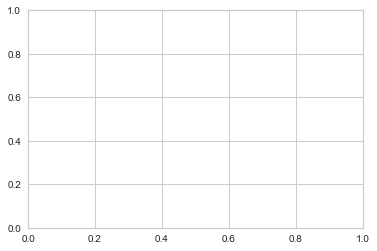

In [4]:
# summarize history for loss
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_NN_model_loss.pdf') as pdf:
    f, ax = plt.subplots()
    plt.plot(history.history['loss'])
    #plt.title('model loss')
    plt.ylabel('model loss', fontsize = 'xx-large')
    plt.xlabel('number of epochs', fontsize = 'xx-large')
    #plt.legend(fontsize = 'xx-large')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    pdf.savefig(f, bbox_inches='tight')

util.regression_report(Y_test, Y_pred, "NN", X.shape[1])

# Analysis

## Residuals 

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(model.predict(X_train)[:,0], util.get_standard_residuals(model.predict(X_train)[:,0],Y_train), c='b', s=40, alpha=0.5)
plt.scatter(model.predict(X_test)[:,0], util.get_standard_residuals(model.predict(X_test)[:,0],Y_test), c='g', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(str(model))
plt.ylabel('Standard Residuals')
plt.xlabel('Fitted values')	   
plt.title("Residuals")
plt.show()

## Predicted vs Original

In [ ]:
#f, ax = plt.subplots(figsize=(8, 6))
#util.pred_true_graph(model_info, "NN")

with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_NN_predicted_vs_original.pdf') as pdf:
    f, ax = plt.subplots(figsize=(6, 6))
    util.pred_true_graph(model_info, "NN")
    #plt.legend(fontsize = 'xx-large')
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
